In [1]:
# Importación de librerías que se utilizarán
import os
import re
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

#import plotly.express as px # Crear gráficos interactivos
import matplotlib.pyplot as plt
from matplotlib import style # Cambiar el estilo visual de los gráficos
import seaborn as sns

import mlflow
import mlflow.sklearn

import nltk #  Librería para procesamiento de lenguaje natural
from nltk.util import ngrams # Crear n-gramas

import pycaret
from pycaret.classification import * # Módulo de PyCaret para problemas de clasificación
from pycaret.utils import version # Obtener la versión de PyCaret instalada
#from pycaret.nlp import * # Módulo de PyCaret para procesamiento de texto

import spacy # Para procesamiento de lenguaje natural.
from spacy.lang.en.examples import sentences # Da ejemplos de frases en español para pruebas.
from spacy.lang.en.stop_words import STOP_WORDS # Stop words en inglés
from nltk.corpus import stopwords # Lista de stopwords pero de la librería NLTK (más general).

import pyLDAvis # Para visualizar modelos de temas
#import pyLDAvis.gensim_models
pyLDAvis.enable_notebook() # Permite que las visualizaciones de pyLDAvis se vean directamente en el notebook
version() # muestra la versión de PyCaret

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    # Este bloque desactiva los mensajes de advertencia para no "ensuciar" la salida de resultados en la consola o notebook.


In [2]:
import pycaret
print(pycaret.__version__)

3.3.2


## 1. Web scraping
This endpoint will receive as input Web scrapping:
- Open web page
- Read the content
- Extract content
- Save all in a data frame

Por el momento el web scraping se realizará con un archivo previamente desacargado de [Kaggle](https://www.kaggle.com/datasets/davidgauthier/glassdoor-job-reviews), para lo que lo cargaremos 

Hubo que instalar lo siguiente: 
* !pip install pycaret
* !python -m spacy download en_core_web_sm
* !python -m spacy download es_core_news_sm
* !pip install pyLDAvis==3.2.2

In [2]:
# Cargamos el archivo con el que trabajaremos
file_path = "C:/Users/palom/OneDrive/Dokumen/CUCEA/2DO_SEM/Challenges-Progra2/Challenge_2/data/glassdoor_reviews.csv"
df = pd.read_csv(file_path)
# Mostramos las primeras filas del archivo para analizar su estructura
df.head()

,firm,date_review,job_title,current,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,outlook,headline,pros,cons
0,AFH-Wealth-Management,2015-04-05,,Current Employee,NaN,2,4.0,3.0,NaN,2.0,3.0,3.0,x,o,r,"Young colleagues, poor micro management",Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication."
1,AFH-Wealth-Management,2015-12-11,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",2,3.0,1.0,NaN,2.0,1.0,4.0,x,o,r,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...
2,AFH-Wealth-Management,2016-01-28,Office Administrator,"Current Employee, less than 1 year","Bromsgrove, England, England",1,1.0,1.0,NaN,1.0,1.0,1.0,x,o,x,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very..."
3,AFH-Wealth-Management,2016-04-16,,Current Employee,NaN,5,2.0,3.0,NaN,2.0,2.0,3.0,x,o,r,Over promised under delivered,Nice staff to work with,No career progression and salary is poor
4,AFH-Wealth-Management,2016-04-23,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",1,2.0,1.0,NaN,2.0,1.0,1.0,x,o,x,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr..."


In [3]:
print(f"Dimensiones del dataframe: {df.shape}")
# obtenemos información del tipo de dato por columna
df.info()

Dimensiones del dataframe: (838566, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838566 entries, 0 to 838565
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   firm                 838566 non-null  object 
 1   date_review          838566 non-null  object 
 2   job_title            838566 non-null  object 
 3   current              838566 non-null  object 
 4   location             541223 non-null  object 
 5   overall_rating       838566 non-null  int64  
 6   work_life_balance    688672 non-null  float64
 7   culture_values       647193 non-null  float64
 8   diversity_inclusion  136066 non-null  float64
 9   career_opp           691065 non-null  float64
 10  comp_benefits        688484 non-null  float64
 11  senior_mgmt          682690 non-null  float64
 12  recommend            838566 non-null  object 
 13  ceo_approv           838566 non-null  object 
 14  outlook              838566 

Se observa que de las 18 variables, 11 son de tipo object, de las cuales 4 de ellas contienen registros vacíos (location, headline, pros, cons).
Observado esto se creará un nuevo dataframe con solo variables _object_ y será este al que se le aplicará el NLP.

In [4]:
df_text = df.select_dtypes(include='object')

# Nos quedamos con los primeros 250 registros del dataframe con la finalidad de trabajar más rápido
df_text = df_text.head(250)
df_text

,firm,date_review,job_title,current,location,recommend,ceo_approv,outlook,headline,pros,cons
0,AFH-Wealth-Management,2015-04-05,,Current Employee,NaN,x,o,r,"Young colleagues, poor micro management",Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication."
1,AFH-Wealth-Management,2015-12-11,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",x,o,r,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...
2,AFH-Wealth-Management,2016-01-28,Office Administrator,"Current Employee, less than 1 year","Bromsgrove, England, England",x,o,x,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very..."
3,AFH-Wealth-Management,2016-04-16,,Current Employee,NaN,x,o,r,Over promised under delivered,Nice staff to work with,No career progression and salary is poor
4,AFH-Wealth-Management,2016-04-23,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",x,o,x,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr..."
...,...,...,...,...,...,...,...,...,...,...,...
245,ALDI,2016-01-14,Area Manager,Current Employee,"London, England, England",v,r,r,Aldi Area Management,"Amazing salary, gives you responsibility nearl...","Hard work, long hours and high expectations. N..."
246,ALDI,2016-01-15,Assistant,Former Employee,"Wigan, England, England",v,o,r,Great to work for,Good hours and pay is ok too,Late hours sometimes and weekends when necessary
247,ALDI,2016-01-25,Anonymous Employee,"Current Employee, more than 1 year","Derby, England, England",v,v,v,Job review,I look at my job as a challenge. If you like t...,You don't a moment for yourself and it would b...
248,ALDI,2016-01-25,Recycling & Cleaning Crew,Former Employee,"Darlington, North East England, England, England",x,r,x,Poor In All Areas,Pay Is Better Than Most Other Warehouse Positi...,No Security What So Ever In Any Position You ...


## 2. Model to classifier and make a sentiment analysis
This part will contein 3 sections:
* Text preprocessing
* Classification proposed
* Extraction of main features

In [5]:
nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\palom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
#### TEXT PREPROCESSING
def limpiar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    # Se convierte todo el texto en str
    nuevo_texto = str(texto)
    # Se convierte todo el texto a minúsculas
    nuevo_texto = nuevo_texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    
    return(nuevo_texto)

In [7]:
# Se aplica la función limpiar a la columna -pros-
# ==============================================================================
df_text['pros'] = df_text['pros'].apply(lambda col: limpiar(col))
df_text

,firm,date_review,job_title,current,location,recommend,ceo_approv,outlook,headline,pros,cons
0,AFH-Wealth-Management,2015-04-05,,Current Employee,NaN,x,o,r,"Young colleagues, poor micro management",very friendly and welcoming to new staff easy ...,"Poor salaries, poor training and communication."
1,AFH-Wealth-Management,2015-12-11,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",x,o,r,"Excellent staff, poor salary",friendly helpful and hard working colleagues,Poor salary which doesn't improve much with pr...
2,AFH-Wealth-Management,2016-01-28,Office Administrator,"Current Employee, less than 1 year","Bromsgrove, England, England",x,o,x,"Low salary, bad micromanagement",easy to get the job even without experience in...,"Very low salary, poor working conditions, very..."
3,AFH-Wealth-Management,2016-04-16,,Current Employee,NaN,x,o,r,Over promised under delivered,nice staff to work with,No career progression and salary is poor
4,AFH-Wealth-Management,2016-04-23,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",x,o,x,client reporting admin,easy to get the job nice colleagues,"Abysmal pay, around minimum wage. No actual tr..."
...,...,...,...,...,...,...,...,...,...,...,...
245,ALDI,2016-01-14,Area Manager,Current Employee,"London, England, England",v,r,r,Aldi Area Management,amazing salary gives you responsibility nearly...,"Hard work, long hours and high expectations. N..."
246,ALDI,2016-01-15,Assistant,Former Employee,"Wigan, England, England",v,o,r,Great to work for,good hours and pay is ok too,Late hours sometimes and weekends when necessary
247,ALDI,2016-01-25,Anonymous Employee,"Current Employee, more than 1 year","Derby, England, England",v,v,v,Job review,i look at my job as a challenge if you like to...,You don't a moment for yourself and it would b...
248,ALDI,2016-01-25,Recycling & Cleaning Crew,Former Employee,"Darlington, North East England, England, England",x,r,x,Poor In All Areas,pay is better than most other warehouse positi...,No Security What So Ever In Any Position You ...


In [8]:
# Creamos una lista de stop words
stop_words = list(stopwords.words('english'))

In [9]:
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df_text['pros_sw'] = df_text['pros'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_text

,firm,date_review,job_title,current,location,recommend,ceo_approv,outlook,headline,pros,cons,pros_sw
0,AFH-Wealth-Management,2015-04-05,,Current Employee,NaN,x,o,r,"Young colleagues, poor micro management",very friendly and welcoming to new staff easy ...,"Poor salaries, poor training and communication.",friendly welcoming new staff easy going ethic
1,AFH-Wealth-Management,2015-12-11,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",x,o,r,"Excellent staff, poor salary",friendly helpful and hard working colleagues,Poor salary which doesn't improve much with pr...,friendly helpful hard working colleagues
2,AFH-Wealth-Management,2016-01-28,Office Administrator,"Current Employee, less than 1 year","Bromsgrove, England, England",x,o,x,"Low salary, bad micromanagement",easy to get the job even without experience in...,"Very low salary, poor working conditions, very...",easy get job even without experience finance
3,AFH-Wealth-Management,2016-04-16,,Current Employee,NaN,x,o,r,Over promised under delivered,nice staff to work with,No career progression and salary is poor,nice staff work
4,AFH-Wealth-Management,2016-04-23,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",x,o,x,client reporting admin,easy to get the job nice colleagues,"Abysmal pay, around minimum wage. No actual tr...",easy get job nice colleagues
...,...,...,...,...,...,...,...,...,...,...,...,...
245,ALDI,2016-01-14,Area Manager,Current Employee,"London, England, England",v,r,r,Aldi Area Management,amazing salary gives you responsibility nearly...,"Hard work, long hours and high expectations. N...",amazing salary gives responsibility nearly str...
246,ALDI,2016-01-15,Assistant,Former Employee,"Wigan, England, England",v,o,r,Great to work for,good hours and pay is ok too,Late hours sometimes and weekends when necessary,good hours pay ok
247,ALDI,2016-01-25,Anonymous Employee,"Current Employee, more than 1 year","Derby, England, England",v,v,v,Job review,i look at my job as a challenge if you like to...,You don't a moment for yourself and it would b...,look job challenge like work fast paced enviro...
248,ALDI,2016-01-25,Recycling & Cleaning Crew,Former Employee,"Darlington, North East England, England, England",x,r,x,Poor In All Areas,pay is better than most other warehouse positi...,No Security What So Ever In Any Position You ...,pay better warehouse positions large site larg...


In [10]:
# Definimos una función para aplicar lemmatization
def lemmatizatizar(text):
    lemmatizer_text = nlp(text)
    lemmatizer_text = [word.lemma_ for word in lemmatizer_text]
    return " ".join(lemmatizer_text)

In [11]:
# Creamos una columna con las lematizaciones para las palabras sin stop words
df_text['pros_lem'] = df_text['pros_sw'].apply(lambda x: lemmatizatizar(x))
df_text

,firm,date_review,job_title,current,location,recommend,ceo_approv,outlook,headline,pros,cons,pros_sw,pros_lem
0,AFH-Wealth-Management,2015-04-05,,Current Employee,NaN,x,o,r,"Young colleagues, poor micro management",very friendly and welcoming to new staff easy ...,"Poor salaries, poor training and communication.",friendly welcoming new staff easy going ethic,friendly welcome new staff easy go ethic
1,AFH-Wealth-Management,2015-12-11,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",x,o,r,"Excellent staff, poor salary",friendly helpful and hard working colleagues,Poor salary which doesn't improve much with pr...,friendly helpful hard working colleagues,friendly helpful hard work colleague
2,AFH-Wealth-Management,2016-01-28,Office Administrator,"Current Employee, less than 1 year","Bromsgrove, England, England",x,o,x,"Low salary, bad micromanagement",easy to get the job even without experience in...,"Very low salary, poor working conditions, very...",easy get job even without experience finance,easy get job even without experience finance
3,AFH-Wealth-Management,2016-04-16,,Current Employee,NaN,x,o,r,Over promised under delivered,nice staff to work with,No career progression and salary is poor,nice staff work,nice staff work
4,AFH-Wealth-Management,2016-04-23,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",x,o,x,client reporting admin,easy to get the job nice colleagues,"Abysmal pay, around minimum wage. No actual tr...",easy get job nice colleagues,easy get job nice colleague
...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,ALDI,2016-01-14,Area Manager,Current Employee,"London, England, England",v,r,r,Aldi Area Management,amazing salary gives you responsibility nearly...,"Hard work, long hours and high expectations. N...",amazing salary gives responsibility nearly str...,amazing salary give responsibility nearly stra...
246,ALDI,2016-01-15,Assistant,Former Employee,"Wigan, England, England",v,o,r,Great to work for,good hours and pay is ok too,Late hours sometimes and weekends when necessary,good hours pay ok,good hour pay ok
247,ALDI,2016-01-25,Anonymous Employee,"Current Employee, more than 1 year","Derby, England, England",v,v,v,Job review,i look at my job as a challenge if you like to...,You don't a moment for yourself and it would b...,look job challenge like work fast paced enviro...,look job challenge like work fast pace environ...
248,ALDI,2016-01-25,Recycling & Cleaning Crew,Former Employee,"Darlington, North East England, England, England",x,r,x,Poor In All Areas,pay is better than most other warehouse positi...,No Security What So Ever In Any Position You ...,pay better warehouse positions large site larg...,pay well warehouse position large site large i...


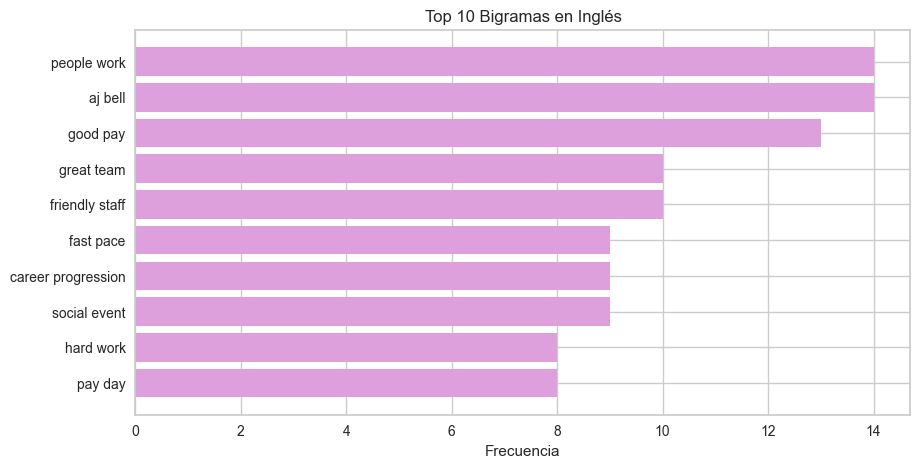

In [20]:
#N-grams, se hace de 2
vectorizer_en = CountVectorizer(ngram_range=(2,2))
X_en = vectorizer_en.fit_transform(df_text['pros_lem'])

bigrams_en = vectorizer_en.get_feature_names_out()
# 1. Sumamos las ocurrencias de cada bigrama
sum_bigrams = X_en.sum(axis=0)

# 2. Creamos un DataFrame con los bigramas y sus frecuencias
bigram_freq = [(bigram, sum_bigrams[0, idx]) for bigram, idx in vectorizer_en.vocabulary_.items()]
bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)

# 3. Convertimos a DataFrame
df_bigrams = pd.DataFrame(bigram_freq, columns=['Bigram', 'Frequency'])

# 4. Tomamos los 10 más comunes
top10 = df_bigrams.head(10)

# 5. Graficamos
plt.figure(figsize=(10,5))
plt.barh(top10['Bigram'], top10['Frequency'], color='plum')
plt.xlabel('Frecuencia')
plt.title('Top 10 Bigramas en Inglés')
plt.gca().invert_yaxis()  # Para que el más frecuente esté arriba
plt.show()

In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\palom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
def generar_ngramas(df, columna, n=2, top=20):
    """
    Genera y grafica los n-gramas más frecuentes de una columna de texto de un DataFrame.

    Parámetros:
    - df: DataFrame de entrada.
    - columna: nombre de la columna de texto.
    - n: tamaño del n-grama (por ejemplo, 2 para bigramas, 3 para trigramas).
    - top: número de n-gramas más frecuentes a graficar.
    """
    # Unir todos los textos en uno solo
    texto_total = ' '.join(df[columna].dropna().astype(str))

    # Tokenizar el texto
    tokens = nltk.word_tokenize(texto_total, language='english')

    # Generar los n-gramas
    n_gramas = list(ngrams(tokens, n))

    # Contar frecuencia de cada n-grama
    contador = Counter(n_gramas)

    # Tomar los 'top' más comunes
    ngramas_mas_comunes = contador.most_common(top)

    # Separar los datos para graficar
    frases = [' '.join(grama) for grama, freq in ngramas_mas_comunes]
    frecuencias = [freq for grama, freq in ngramas_mas_comunes]

    # Crear el gráfico
    plt.figure(figsize=(10, 6))
    plt.barh(frases[::-1], frecuencias[::-1], color='skyblue')
    plt.xlabel('Frecuencia')
    plt.title(f'Top {top} {n}-gramas más frecuentes')
    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
# generar_ngramas(df=mi_dataframe, columna='mi_columna_texto', n=2, top=15)



In [15]:
generar_ngramas(df_text,'pros_lem',2,10)

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\palom/nltk_data'
    - 'c:\\Users\\palom\\anaconda3\\envs\\ProgramacionII\\nltk_data'
    - 'c:\\Users\\palom\\anaconda3\\envs\\ProgramacionII\\share\\nltk_data'
    - 'c:\\Users\\palom\\anaconda3\\envs\\ProgramacionII\\lib\\nltk_data'
    - 'C:\\Users\\palom\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


## 3. Create a pipline to MLOps